In [1]:
from extract_desserts import *
from pattern.text.en import singularize
from nltk import FreqDist
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(seed=2019)

import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    datefmt='%H:%M:%S',
                   level=logging.INFO)

from time import time
import multiprocessing

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load the raw data
# lets use the default value that only loads 250 recipes,
# instead of 1 million
# raw_data = get_raw_data('sample_50k_layer1.json')
# raw_ingredients = get_raw_ingredients('sample_50k_det_ingrs.json')

# load a total of 20k recipes
raw_data = get_raw_data('sample_layer1.json')
raw_ingredients = get_raw_ingredients('sample_det_ingrs.json')

Loading file  ../data/sample_layer1.json
Loading ingredient file: ../data/sample_det_ingrs.json


In [3]:
print('N recipes: {}\t N list of ingredients: {}'.format(len(raw_data),
      len(raw_ingredients)))


N recipes: 20000	 N list of ingredients: 20000


In [4]:
## get a list of desserts only
desserts, dessert_ings = find_desserts(raw_data, raw_ingredients)#,test_id='02916fd389')


In [5]:
total_recipes = len(raw_data)
dessert_recipes = len(desserts)
dessert_ingredients = len(dessert_ings)
print('Will look at {} dessert recipes, out of {} (~{:1.1f}%)'.format(
                            dessert_recipes, total_recipes,
                            dessert_recipes/total_recipes*100))

Will look at 3848 dessert recipes, out of 20000 (~19.2%)


In [14]:
import re

not_a_flavor_list = ['flour','cake mix','baking soda','baking powder', 'canola oil',
                     'vegetable oil','cornstarch','shortening','margarine','yeast',
                     'gelatin' ,'coloring','corn syrup','cooking spray', 
         'crisco', 'cake', 'crisco','xanthan','bicarbonate','pie shell','pie crust',
                     'cornmeal','splenda','stevium','ice cube', 'gluten','bread'
                    ]

generic_ingredient_list = ['pumpkin', 'vanilla','cinnammon','cocoa powder',
                           'chocolate chip','salted butter', 'graham cracker','mint',
                          'salted butter','coffee']



In [15]:



def in_not_a_flavor_list(ingredient):
    for word in not_a_flavor_list:
        if re.search(word, ingredient):
            return True   
    return False


def is_generic_ingredient(ingredient):
    for word in generic_ingredient_list:
#         print(word,ingredient)
        if re.search(word, ingredient):
            return True, word
    return False, ingredient

def clean_dessert_ingredients(all_ingredients):
    count =0
    for item, ingredients_list in enumerate(all_ingredients):
        to_remove = []
        for ingr_item, ingredient in enumerate(ingredients_list['ingredients']):
            tmp_ingredient = ingredient['text'].lower().replace(' - ','-')
            tmp_ingredient = tmp_ingredient.replace("'",'')
            tmp_ingredient = tmp_ingredient.replace(" & ",'&')
            tmp_ingredient = tmp_ingredient.replace('fat free', 'fat-free')
#             tmp_ingredient = singularize(tmp_ingredient)
            
#             print(ingredient['text'].replace(' - ','-'))
            if re.search('water', tmp_ingredient) and not re.search('watermelon',tmp_ingredient) and not re.search('rose water',tmp_ingredient):
                to_remove.append(ingr_item)
            
            if in_not_a_flavor_list(tmp_ingredient):
                to_remove.append(ingr_item)
            elif re.match('oil', tmp_ingredient):
                to_remove.append(ingr_item)

                        
            
            if re.search('heavy', tmp_ingredient) and re.search('cream',tmp_ingredient):
                tmp_ingredient='heavy cream'
            
            generic_ingr, ingr = is_generic_ingredient(tmp_ingredient)
            if generic_ingr:
                tmp_ingredient = ingr

                
#             elif (re.search('purpose flour', tmp_ingredient) 
#                   or re.search('cake flour',tmp_ingredient) 
#                   or re.search('rising flour', tmp_ingredient) 
#                   or re.search('plain flour', tmp_ingredient)
#                   or re.search('white flour', tmp_ingredient)
#                   or re.search('raising flour', tmp_ingredient)

#                  ):
#                 tmp_ingredient = 'flour' 
            elif re.search('brown sugar', tmp_ingredient) or re.search('demerara sugar', tmp_ingredient):
                tmp_ingredient = 'brown sugar'
            
            elif re.search('powdered sugar', tmp_ingredient) or re.search('confectioners sugar',tmp_ingredient) :
                tmp_ingredient ='powdered sugar'
            elif re.search('sugar', tmp_ingredient) or re.search('white sugar', tmp_ingredient) or re.search('granulated sugar',tmp_ingredient):
                tmp_ingredient = 'sugar'

            elif re.search('semi-sweet', tmp_ingredient) and re.search('chocolate',tmp_ingredient):
                tmp_ingredient = 'chocolate'

            if (not re.search('flour', tmp_ingredient) 
                and not re.search('molasses',tmp_ingredient)
                and not re.search('oats',tmp_ingredient)):
                tmp_ingredient = singularize(tmp_ingredient)


            all_ingredients[item]['ingredients'][ingr_item]['text'] = tmp_ingredient
            
        if len(to_remove)>0:
            
            to_remove.sort(reverse=True)
            
                
#             print(item,'to remove', to_remove)
            for i in to_remove:
#                 print('try to remove', all_ingredients[item]['ingredients'][i])
                del all_ingredients[item]['ingredients'][i]
#         for iremove in to_remove:
#             del all_ingredients
#         print('--------------------------')
        if item%500==0:
            logging.info("read {0} recipes".format(item))
    return all_ingredients

def print_dessert_ingredients(all_ingredients):
    count =0
    for item, ingredients_list in enumerate(all_ingredients):
        for ingr_item, ingredient in enumerate(ingredients_list['ingredients']):
            
            
            print(ingredient['text'])
        
        print('--------------------------')
        if item==50:
            break
    return all_ingredients

In [16]:
clean_ingredients =  clean_dessert_ingredients(dessert_ings);
# print_dessert_ingredients(clean_ingredients)
# print(dessert_ings)


10:09:03 : INFO : read 0 recipes
10:09:03 : INFO : read 500 recipes
10:09:04 : INFO : read 1000 recipes
10:09:04 : INFO : read 1500 recipes
10:09:04 : INFO : read 2000 recipes
10:09:05 : INFO : read 2500 recipes
10:09:05 : INFO : read 3000 recipes
10:09:06 : INFO : read 3500 recipes


In [17]:
len(clean_ingredients)
# item = np.random.randint(dessert_recipes)
# print(item, dessert_ings[item]['valid'])
# dessert_ings[item]['ingredients']

3848

# Let's look at the unique words for a Word2Vec

In [30]:
item=0
len(dessert_ings),len(dessert_ings[item]['ingredients'])

(3848, 4)

## Lets create a list of ingredients
And we will us it as an input to word2Vec

In [19]:
ingredients_per_recipe = []
count =0
for drecipe in dessert_ings:
    ings =[]
    for entry in drecipe['ingredients']:
        ings.append(entry['text'])
    ingredients_per_recipe.append(ings)
    count += 1
    if count%500==0:
        logging.info("read {0} ingredients".format(count))

#         break;

# print(all_dingredients)

10:10:40 : INFO : read 500 ingredients
10:10:40 : INFO : read 1000 ingredients
10:10:40 : INFO : read 1500 ingredients
10:10:40 : INFO : read 2000 ingredients
10:10:40 : INFO : read 2500 ingredients
10:10:40 : INFO : read 3000 ingredients
10:10:40 : INFO : read 3500 ingredients


In [14]:
ingredients_per_recipe[0]

['fresh rhubarb', 'frozen rhubarb', 'sugar', 'butter']

## Create a Word2Vec model training on the ingredients. 


In [31]:
vec_size = 100;
model = gensim.models.Word2Vec(
   # all_dingredients,
    size=vec_size,
    window=5,
    min_count=20,
    workers=10,
    alpha=0.02,
    iter=4,
    sg=0)

In [16]:
t = time()
model.build_vocab(ingredients_per_recipe, progress_per=1000)

16:16:29 : INFO : collecting all words and their counts
16:16:29 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
16:16:29 : INFO : PROGRESS: at sentence #1000, processed 7132 words, keeping 954 word types
16:16:29 : INFO : PROGRESS: at sentence #2000, processed 14320 words, keeping 1456 word types
16:16:29 : INFO : PROGRESS: at sentence #3000, processed 21242 words, keeping 1824 word types
16:16:29 : INFO : collected 2110 word types from a corpus of 27488 raw words and 3848 sentences
16:16:29 : INFO : Loading a fresh vocabulary
16:16:29 : INFO : min_count=20 retains 136 unique words (6% of original 2110, drops 1974)
16:16:29 : INFO : min_count=20 leaves 22374 word corpus (81% of original 27488, drops 5114)
16:16:29 : INFO : deleting the raw counts dictionary of 2110 items
16:16:29 : INFO : sample=0.001 downsamples 57 most-common words
16:16:29 : INFO : downsampling leaves estimated 7952 word corpus (35.5% of prior 22374)
16:16:29 : INFO : estimated required m

In [17]:
model.train(ingredients_per_recipe, total_examples=model.corpus_count,
           epochs=40, report_delay=1)

16:16:34 : INFO : training model with 10 workers on 136 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
16:16:34 : INFO : worker thread finished; awaiting finish of 9 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 8 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 7 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 6 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 5 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 4 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 3 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 2 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 1 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 0 more threads
16:16:34 : INFO : EPOCH - 1 : training on 27488 raw words (7903 effective words) took 0.0s, 391156 effecti

16:16:34 : INFO : worker thread finished; awaiting finish of 6 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 5 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 4 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 3 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 2 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 1 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 0 more threads
16:16:34 : INFO : EPOCH - 10 : training on 27488 raw words (8052 effective words) took 0.0s, 386746 effective words/s
16:16:34 : INFO : worker thread finished; awaiting finish of 9 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 8 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 7 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 6 more threads
16:16:34 : INFO : worker thread finished; awai

16:16:34 : INFO : worker thread finished; awaiting finish of 2 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 1 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 0 more threads
16:16:34 : INFO : EPOCH - 19 : training on 27488 raw words (7966 effective words) took 0.0s, 350381 effective words/s
16:16:34 : INFO : worker thread finished; awaiting finish of 9 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 8 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 7 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 6 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 5 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 4 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 3 more threads
16:16:34 : INFO : worker thread finished; awaiting finish of 2 more threads
16:16:34 : INFO : worker thread finished; awai

16:16:35 : INFO : worker thread finished; awaiting finish of 9 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 8 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 7 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 6 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 5 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 4 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 3 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 2 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 1 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 0 more threads
16:16:35 : INFO : EPOCH - 29 : training on 27488 raw words (7949 effective words) took 0.0s, 423370 effective words/s
16:16:35 : INFO : worker thread finished; awaiting finish of 9 more threads
16:16:35 : INFO : worker thread finished; awai

16:16:35 : INFO : worker thread finished; awaiting finish of 5 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 4 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 3 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 2 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 1 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 0 more threads
16:16:35 : INFO : EPOCH - 38 : training on 27488 raw words (7914 effective words) took 0.0s, 353255 effective words/s
16:16:35 : INFO : worker thread finished; awaiting finish of 9 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 8 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 7 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 6 more threads
16:16:35 : INFO : worker thread finished; awaiting finish of 5 more threads
16:16:35 : INFO : worker thread finished; awai

(317840, 1099520)

In [18]:
model.init_sims(replace=True)

16:16:40 : INFO : precomputing L2-norms of word weight vectors


In [19]:
w1='apple'
# w1='rum'
model.wv.most_similar(positive=w1, topn=10)

[('raisin', 0.9913337230682373),
 ('applesauce', 0.977846622467041),
 ('carrot', 0.971808671951294),
 ('clove', 0.9607939720153809),
 ('ginger', 0.9582724571228027),
 ('apple juice', 0.9580904841423035),
 ('unsweetened applesauce', 0.9540296792984009),
 ('nutmeg', 0.9530465602874756),
 ('allspice', 0.9498273134231567),
 ('cinnamon', 0.9492180943489075)]

In [20]:

model.wv.most_similar(positive=['apple','banana'],
                      negative=['butter'],topn=10)

[('oats', 0.8970291614532471),
 ('unsweetened applesauce', 0.8747656345367432),
 ('honey', 0.87437903881073),
 ('rolled oats', 0.8737241625785828),
 ('applesauce', 0.8705345392227173),
 ('olive oil', 0.8584024906158447),
 ('apple juice', 0.8570231199264526),
 ('date', 0.8411449193954468),
 ('granny smith apple', 0.8403807878494263),
 ('raisin', 0.835991382598877)]

In [ ]:
# witem = model.wv.__getitem__(['ginger'])
# witem[0]

In [22]:
model.wv.doesnt_match(['apple','butter','banana',
                       'rum'])

'apple'

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.decomposition import PCA


from mpl_toolkits.mplot3d import Axes3D

In [24]:

def ingredient_scatterplot(model, word):
    # create an array with the same size as the vector
    arrays = np.empty((0,vec_size), dtype='f')
    # set the original word,     
    word_labels = [word]
    color_list = ['red']
    # append the vector for the test word
    arrays = np.append(arrays, model.wv.__getitem__([word]),axis=0)
    
    ####### get the closest words and make then blue
    #get a list of the most similar words
    close_words = model.wv.most_similar([word],topn=25)
    
    for word_score in close_words:
        # for each word get the vector  
        word_vector = model.wv.__getitem__([word_score[0]])
        # get the name
        word_labels.append(word_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, word_vector, axis=0)
             
    Y = PCA(n_components=2).fit_transform(arrays)
    
    df = pd.DataFrame({'x':[x for x in Y[:, 0]],
                       'y':[y for y in Y[:, 1]],
#                        'z':[z for z in Y[:, 2]],
                       'words':word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(8,6)
    
    p1 = sns.regplot(data=df, 
                    x='x',y='y',fit_reg=False,
                    marker='x',
                    scatter_kws={'s':40,
                                'facecolors':df['color']})
    
    for line in range(df.shape[0]):
        p1.text(df['x'][line],df['y'][line],#df['z'][line],
               '  '+df['words'][line].title(),
               horizontalalignment='left',
                verticalalignment='bottom',size='large',
                color=df['color'][line],weight='normal'
               ).set_size(10)
#     fig = plt.figure(figsize=(8,6))
#     ax = Axes3D(fig)  
    
#     ax.scatter(df['x'], df['y'], df['z'], marker='o')
    plt.xlim(Y[:,0].min()-0.1, Y[:,0].max()+0.1 )
    plt.ylim(Y[:,1].min()-0.1, Y[:,1].max()+0.1 )
#     plt.zlim(Y[:,2].min(), Y[:,2].max() )
    plt.title('Food pairing for {}'.format(word.title()))

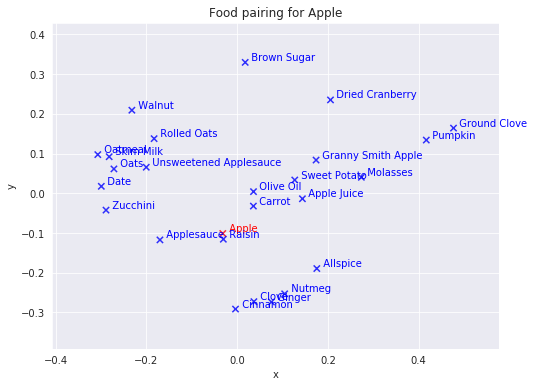

In [25]:
ingredient_scatterplot(model, 'apple')

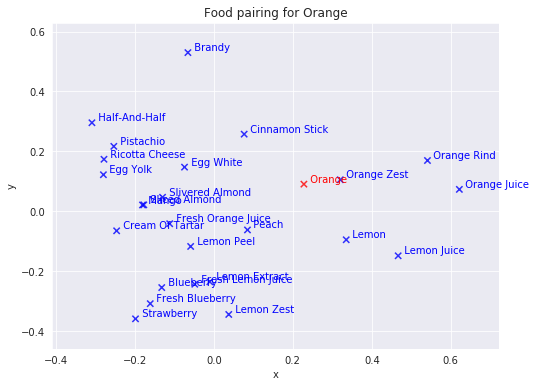

In [28]:
test_word = 'orange'
ingredient_scatterplot(model, test_word)

### Make a network graph

In [ ]:
import networkx as nx


In [ ]:

w1='rum'
ingred_list = model.wv.most_similar(positive=w1, topn=20)

# print(ingred_list)
G = nx.Graph()
G.add_node(w1,nodesize=20)
for n_node, ingred in enumerate(ingred_list):
    G.add_node(ingred[0], nodesize=ingred[1]*10)
    G.add_weighted_edges_from([(w1, ingred[0], ingred[1])])
               
sizes = [G.node[node]['nodesize']*300 for node in G]
        #     G.add_edge(1,n_node+2)
# G.add_nodes_from([1,2,3,4,5,6,7])
# G.add_edge(1,2)
# G.add_edge(1,3)
# G.add_edge(1,4)
# G.add_edge(1,5)
# G.add_edge(1,6)
# G.add_edge(1,7)

# G.node[1]['label']='blue'
# G.add_edge(1,4)

plt.figure(figsize=(10,8))

options = {
    'edge_color': '#4C34EB',
    'width': 1,
    'with_labels': True,
    'font_weight': 'heavy',
}

nx.draw(G,  node_size=sizes, 
        pos=nx.spring_layout(G, k=0.5, iterations=50), **options)
# ax = plt.gca()
# ax.collections[0].set_edgecolor('#5555')
# plt.show()

In [ ]:
G.nodes

## look at unique values

In [20]:
# create bag of ingredients

all_ingredients = []

for recipe_ings in clean_ingredients:# dessert_ings:
    n_ingredients = len(recipe_ings['valid'])
    for item, ingredient in enumerate(recipe_ings['ingredients']):
#         if recipe_ings['valid'][item] ==True:
        ingred = ingredient['text'].lower()

        all_ingredients.append(ingred)
                

            

In [21]:

### Funciton to retrieve reciepes given an ingredient list

def get_recipes_for_ingredients(search_list, ingredients_list, recipe_list):
    """
    Function to look for a recipe with all the ingredients in  the list passed
    
    Output:
        List of ingredients.
    """
    
    found_recipe_list = []
    found_ingredient_list = []
    for item,recipe_ingrs in enumerate(ingredients_list):
        temp_ingr_list = []
        ingredients = recipe_ingrs['ingredients']
        n_ingredients = len(ingredients)
        found_ingredient =0
        for ingredient in ingredients:
            if re.search(search_list[0], ingredient['text']):
                found_ingredient=1
            temp_ingr_list.append(ingredient['text'])

        # find all elements in the list
#         result = all(elem in temp_ingr_list for elem in search_list)
        # find any elements in the list
        result = any(singularize(elem) in temp_ingr_list for elem in search_list)
        
        
        if result or found_ingredient==1:
            found_recipe_list.append(recipe_list[item])
            found_ingredient_list.append(temp_ingr_list)
#             print('adding item', item)
           
    
    
    
    return found_recipe_list, found_ingredient_list
    

In [17]:
# all_ingredients

In [22]:
ingredient_set = set(all_ingredients)
print('with {} recipes, there are {} ingredients, and {} unique ingredients.'.format(
                dessert_recipes, len(all_ingredients), len(ingredient_set)))

with 3848 recipes, there are 27488 ingredients, and 2110 unique ingredients.


In [32]:
ingredient_set = set(all_ingredients)
print('with {} recipes, there are {} ingredients, and {} unique ingredients.'.format(
                dessert_recipes, len(all_ingredients), len(ingredient_set)))

with 3848 recipes, there are 27488 ingredients, and 2110 unique ingredients.


In [23]:
fdist = FreqDist(all_ingredients)
print(fdist)

<FreqDist with 2110 samples and 27488 outcomes>


In [25]:
common = fdist.most_common(500)

In [26]:
# common
# f= open("words.txt","w+")
for cc in common:
    if re.search('pie', cc[0]) and cc[1]>10:
        print(cc)
#     f.write('{}: \t {}\n'.format(cc[0], cc[1]))

('cherry pie filling', 16)
('toffee piece', 12)


In [27]:
common

[('sugar', 2853),
 ('vanilla', 2066),
 ('egg', 1853),
 ('salt', 1659),
 ('butter', 1513),
 ('brown sugar', 846),
 ('milk', 741),
 ('salted butter', 632),
 ('powdered sugar', 564),
 ('chocolate chip', 450),
 ('cinnamon', 444),
 ('heavy cream', 355),
 ('ground cinnamon', 338),
 ('egg yolk', 297),
 ('cream cheese', 290),
 ('pecan', 267),
 ('cocoa powder', 243),
 ('honey', 237),
 ('walnut', 236),
 ('egg white', 208),
 ('banana', 199),
 ('nutmeg', 176),
 ('pumpkin', 174),
 ('buttermilk', 173),
 ('lemon juice', 171),
 ('sour cream', 154),
 ('whipping cream', 141),
 ('coffee', 127),
 ('raisin', 123),
 ('ground nutmeg', 117),
 ('almond extract', 110),
 ('nut', 107),
 ('ground ginger', 103),
 ('peanut butter', 101),
 ('cocoa', 101),
 ('ground clove', 96),
 ('apple', 95),
 ('whole milk', 95),
 ('lemon', 90),
 ('chocolate', 87),
 ('strawberry', 85),
 ('low-fat milk', 84),
 ('sweetened condensed milk', 84),
 ('orange juice', 82),
 ('evaporated milk', 82),
 ('semisweet chocolate', 81),
 ('bitterswe

In [28]:
found_lists, found_ingredients = get_recipes_for_ingredients(['pasta'], dessert_ings,desserts)
print('found {} recipes'.format(len(found_lists)))

for item, rec in enumerate(found_lists):
    print('{}\t{}'.format(item, rec['title']))

found 1 recipes
0	Chocolate Stuffed Shells


In [29]:
item = 0
found_lists[item],found_ingredients[item]

({'ingredients': [{'text': '24 jumbo shells, conchiglioni, preferably Felicetti brand'},
   {'text': 'Salt'},
   {'text': '1/4 cup (20 g) unsweetened cocoa powder'},
   {'text': "1/2 cup (50 g) confectioners' sugar, optional"},
   {'text': 'Approximately 2 cups (480 ml) total of gelato, custard, whipped cream, pudding, fruit, yogurt, etc.'}],
  'url': 'http://www.cookstr.com/recipes/chocolate-stuffed-shells',
  'partition': 'train',
  'title': 'Chocolate Stuffed Shells',
  'id': '04d61588d7',
  'instructions': [{'text': 'Boil the shells in lightly salted water until they are al dente and drain.'},
   {'text': "For sweeter shells, put the cocoa powder and confectioners' sugar, to taste, into a sturdy plastic food -storage bag."},
   {'text': 'Toss the shells, a few at a time, into the bag until fully coated with cocoa powder.'},
   {'text': 'For less sweet shells, toss them in just the cocoa powder.'},
   {'text': 'Using a teaspoon, fill the shells with anything you like.'},
   {'text':

In [ ]:
test = 'onio'

for ingr in found_ingredients[82]:
    if re.match(test, ingr):
        print('----> found a',test, ingr)
    else:
        print(ingr)

In [ ]:
test_ingredients = []
for ingred in dessert_ings[2029]['ingredients']:
    test_ingredients.append(ingred['text'])
print(test_ingredients)

In [ ]:
food_pattern = 'flourish'
# for ing in test_ingredients:
m = re.search(food_pattern, 'vanilla and flour don')
print(m)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 8))
# plt.ylim(0,120)
fdist.plot(50,cumulative=False)
# plt.ylim(0,30)
# plt.show()

In [ ]:
import nltk
from nltk.corpus import stopwords
import string

from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
np.random.seed(23)

In [ ]:
stopwords_list  = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list +=

In [ ]:
stopwords_list[-20:]

In [ ]:
# import spacy

In [ ]:
# !python -m spacy download en

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import spacy

In [ ]:
nlp = spacy.load('en')

In [ ]:
desserts[3204]['instructions']

test_instructions = ''

for instr in desserts[3204]['instructions']:
    test_instructions += instr['text'] + ' '
    
print(test_instructions)

In [ ]:
parsed_text = nlp(test_instructions)

In [ ]:
parsed_text

In [ ]:
for num, entity in enumerate(nlp(test_instructions).ents):
    print(num+1,'Entity: ',entity, entity.label_)

In [ ]:
token_pos = [token.pos for token in nlp(test_instructions)]
tokens = [token for token in nlp(test_instructions)]
sd = list(zip(tokens, token_pos))
sd = pd.DataFrame(sd, columns=['token','pos'])
sd.head()

In [ ]:
sd

In [ ]:
max_num_words = 1000
max_seg_length = 100
tokenizer = Tokenizer(num_words=max_num_words)

## get categories

In [6]:
item = np.random.randint(len(desserts))
desserts[item]['title']

'Peanut Butter Rice Krispies Bars Recipe'

In [7]:
categories = ['cake', 'cookies', 'pie','bread','cupcake','candy', 'pudding','custard']

In [8]:
def classify_desserts(recipes, recipe_ingredients):
    n_recipes = 0
    n_classified =0
    new_recipe_list = []
    new_recipe_ingredients = []
    category_list = []
    for item, recipe in enumerate(recipes):
        title = recipe['title']
        title = title.lower().split(' ')
        for category in categories:
            if category in title:
#                 print(category)
                n_classified +=1
                recipe['type'] = category
                new_recipe_list.append(recipe)
                all_ingredients = ''
                for ingredient in recipe_ingredients[item]['ingredients']:
                    all_ingredients += ingredient['text'] + ' '
                new_recipe_ingredients.append(all_ingredients)
                category_list.append(category)
                break
            
        
#         print(title)
        n_recipes += 1
        if n_recipes%250==0:
            logging.info("read {0} recipes".format(n_recipes))
#             break
    return new_recipe_list, new_recipe_ingredients, category_list

In [9]:
desserts, dessert_ings
new_data, new_data_ings, target = classify_desserts(desserts,dessert_ings)

print('classified {0}/{1}'.format(len(new_data),len(new_data_ings)))

14:45:15 : INFO : read 250 recipes
14:45:15 : INFO : read 500 recipes
14:45:15 : INFO : read 750 recipes
14:45:15 : INFO : read 1000 recipes
14:45:15 : INFO : read 1250 recipes
14:45:15 : INFO : read 1500 recipes
14:45:15 : INFO : read 1750 recipes
14:45:15 : INFO : read 2000 recipes
14:45:15 : INFO : read 2250 recipes
14:45:15 : INFO : read 2500 recipes
14:45:15 : INFO : read 2750 recipes
14:45:15 : INFO : read 3000 recipes
14:45:15 : INFO : read 3250 recipes
14:45:15 : INFO : read 3500 recipes
14:45:15 : INFO : read 3750 recipes


classified 2062/2062


In [10]:
import pandas as pd
df = pd.DataFrame([new_data_ings,target]).T

In [11]:
df.columns = ['ingredients','dessert']
df.head()

,ingredients,dessert
0,fresh rhubarb frozen rhubarb granulated sugar ...,cake
1,flour cinnamon baking soda salt baking powder ...,bread
2,vanilla wafer cookie bananas coconut milk fat ...,pie
3,all - purpose flour white sugar salt vegetable...,pie
4,"2 cups peeled, cooked, mashed sweet potatoes* ...",pie


In [15]:
df['dessert'].value_counts()

0    1412
1     650
Name: dessert, dtype: int64

In [13]:
df['dessert'] = np.where(df['dessert']=='cake', 1, 0)

In [14]:
df.head()
df.shape

(2062, 2)

In [16]:
text = df.ingredients.values
label = df.dessert.values

In [17]:
# nlp = spacy.load('en')

In [119]:
# text[0]

'fresh rhubarb frozen rhubarb granulated sugar strawberry Jell - O gelatin dessert white cake mix water butter '

In [120]:
# parsed_text = nlp(text[10])
# parsed_text

margarine instant chocolate pudding mix egg flour sugar apricot preserves semi - sweet chocolate chips margarine 

In [121]:
# for sent in parsed_text.ents:
#     print(sent, sent.label_)

In [105]:
# token_pos = [token.pos_ for token in nlp(text[10])]
# tokens = [token for token in nlp(text[10])]
# sd = list(zip(tokens, token_pos))
# sd = pd.DataFrame(sd, columns=['token','pos'])
# sd

In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import spacy

max_num_words= 1000
max_seq_length = 100
tokenizer = Tokenizer(num_words = max_num_words)

Using TensorFlow backend.


In [20]:
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
word_index = tokenizer.word_index

In [21]:
data = pad_sequences(sequences, maxlen=max_seq_length)
data.shape

(2062, 100)

In [22]:
label = to_categorical(np.asarray(label))
label

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [23]:
label.shape

(2062, 2)

In [24]:
validation_split = 0.2
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [25]:
data = data[indices]
data

array([[  0,   0,   0, ...,  50,  56,  11],
       [  0,   0,   0, ...,  30,   1,   7],
       [  0,   0,   0, ...,  86, 136,  39],
       ...,
       [  0,   0,   0, ..., 344, 122, 771],
       [  0,   0,   0, ...,  32, 152,   1],
       [  0,   0,   0, ...,  52, 512,  57]], dtype=int32)

In [26]:
label = label[indices]
label

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [27]:
nb_validation_samples = int(validation_split*data.shape[0])
nb_validation_samples

412

In [28]:
x_train = data[:-nb_validation_samples]
y_train = label[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = label[-nb_validation_samples:]

In [135]:
glove_dir = '../data/glove_data/'

In [29]:
embedding_index = {}
f = open('../data/glove_data/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close

print('found word vecs: ', len(embedding_index))

found word vecs:  400000


In [30]:
embedding_dim = 50
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
embedding_matrix.shape

(1256, 300)

In [31]:
embedding_dim

300

In [32]:
count =0
for word,i in word_index.items():
    if count%10==0:
        print(count,end='.')
    count+=1
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

0.

ValueError: could not broadcast input array from shape (50) into shape (300)

In [ ]:
from keras.layers import Embedding
embedding_layer = Embedding(len(word_index)+1,
                            embedding_dim,weights=[embedding_matrix],input_length=max_seq_length,trainable=False)

In [ ]:
from keras.layers import Bidirectional,GlobalMaxPool1D,Conv1D
from keras.layers import LSTM,Input,Dense,Dropout,Activation
from keras.models import Model

In [ ]:
inp = Input(shape=(max_seq_length,))
x = embedding_layer(inp)
x = Bidirectional(LSTM(50,return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50,activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(2,activation='sigmoid')(x)
model = Model(inputs=inp,outputs=x)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

In [ ]:
model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=20,batch_size=128);

In [ ]:
score = model.evaluate(x_val,y_val)
score

## try gloVe

In [38]:
import numpy as np

In [39]:
with open("../data/glove_data/glove.6B.300d.txt","rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
          for line in lines}
        

In [44]:
import gensim
model = gensim.models.Word2Vec(ingredients_per_recipe, size=100)

11:16:43 : INFO : collecting all words and their counts
11:16:43 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
11:16:43 : INFO : collected 2110 word types from a corpus of 27488 raw words and 3848 sentences
11:16:43 : INFO : Loading a fresh vocabulary
11:16:43 : INFO : min_count=5 retains 420 unique words (19% of original 2110, drops 1690)
11:16:43 : INFO : min_count=5 leaves 24890 word corpus (90% of original 27488, drops 2598)
11:16:43 : INFO : deleting the raw counts dictionary of 2110 items
11:16:43 : INFO : sample=0.001 downsamples 52 most-common words
11:16:43 : INFO : downsampling leaves estimated 10831 word corpus (43.5% of prior 24890)
11:16:43 : INFO : estimated required memory for 420 words and 100 dimensions: 546000 bytes
11:16:43 : INFO : resetting layer weights
11:16:43 : INFO : training model with 3 workers on 420 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
11:16:43 : INFO : worker thread finished; awaiting f

In [46]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [45]:

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

In [49]:
etree_w2v = Pipeline([
    ('word2vec vectorizer', MeanEmbeddingVectorizer(w2v)),
    ('extra trees', ExtraTreesClassifier(n_estimators=200))
])

AttributeError: 'dict' object has no attribute 'itervalues'